In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("poster")

%matplotlib inline

In [2]:
colnames = ["chr", "start", "end", "period", "unit"]
df_strs = (
    pd.read_csv("../../data/hg38_ver13_0boe_mononucleotides.bed", sep="\t", header=None, names=colnames)
    .assign(str_id = lambda x: [f"{i}_{j}" for i, j in zip(x["chr"], x["start"])])
)
df_strs

,chr,start,end,period,unit,str_id
0,chr1,14069,14081,4,CCTC,chr1_14069
1,chr1,16619,16631,3,GCT,chr1_16619
2,chr1,22811,22821,5,AGGAA,chr1_22811
3,chr1,26453,26465,2,GT,chr1_26453
4,chr1,28588,28603,1,T,chr1_28588
...,...,...,...,...,...,...
1733641,chrY,57188867,57188878,1,A,chrY_57188867
1733642,chrY,57200837,57200851,1,A,chrY_57200837
1733643,chrY,57200999,57201019,1,A,chrY_57200999
1733644,chrY,57202380,57202403,1,A,chrY_57202380


In [3]:
file_dict = {
    "LMO": "../../data/CRC/variants/CRC0282LMO-0-B_constrain.csv.gz", 
    "01-0": "../../data/CRC/variants/CRC0282-01-0_constrain.csv.gz",
    "05-0": "../../data/CRC/variants/CRC0282-05-0_constrain.csv.gz",
    "07-0": "../../data/CRC/variants/CRC0282-07-0_constrain.csv.gz",
}

df_pairs = pd.DataFrame({
    "left": ["LMO", "LMO", "LMO", "05-0", "05-0", "01-0"],
    "right": ["01-0", "05-0", "07-0", "01-0", "07-0", "07-0"],
    "left_n": [2, 2, 2, 2, 2, 4],
    "dupe_left": [True, False, True, True, True, False]
})
df_pairs

,left,right,left_n,dupe_left
0,LMO,01-0,2,True
1,LMO,05-0,2,False
2,LMO,07-0,2,True
3,05-0,01-0,2,True
4,05-0,07-0,2,True
5,01-0,07-0,4,False


In [4]:
def simulate_wgd(genotypes: pd.Series) -> pd.Series:
    wgd = []
    for i in genotypes:
        wgd.append(list(np.repeat(eval(i), 2)))
    return pd.Series(wgd)

def str_distance(df_comp):
    distance = 0
    for i, j in zip(df_comp["genotype_left"], df_comp["genotype_right"]):
        if isinstance(i, str):
            i = eval(i)
        if isinstance(j, str):
            j = eval(j)
        distance += np.sum(np.abs(np.array(i) - np.array(j)))
    print(f"n comparisons: {df_comp.shape[0]}")
    return distance / df_comp.shape[0]

def compare_samples(df_left, df_right, dupe_left, df_repeats, df_distances):
    df_left = df_left.dropna().merge(df_repeats[["str_id", "period"]])
    df_left = df_left.query("period > 2 and period <= 6 and depth_norm >= 5").reset_index(drop=True)
    
    df_right = df_right.dropna().merge(df_repeats[["str_id", "period"]])
    df_right = df_right.query("period > 2 and period <= 6 and depth_norm >= 5").reset_index(drop=True)

    if dupe_left:
        df_left["genotype"] = simulate_wgd(df_left["genotype"])
        df_left = df_left.assign(copy_number = lambda x: x["copy_number"] * 2)

    df_comp = df_left.merge(df_right, 
                            on=["str_id", "copy_number"], 
                            suffixes=("_left", "_right"), 
                            how="inner")
    
    return str_distance(df_comp)
    

In [5]:
%%time

df_distances = pd.DataFrame(np.zeros((4, 4)), index=["LMO", "01-0", "05-0", "07-0"], columns=["LMO", "01-0", "05-0", "07-0"])

for _, row in df_pairs.iterrows():
    print(row["left"], "vs.", row["right"])
    
    left = pd.read_csv(file_dict[row["left"]])
    right = pd.read_csv(file_dict[row["right"]])
    
    distance = compare_samples(left, right, row["dupe_left"], df_strs, df_distances)
    df_distances.loc[row["left"], row["right"]] = distance
    df_distances.loc[row["right"], row["left"]] = distance
    
    print()

df_distances.index = df_distances.columns = ["Main bulk (2n)", "Clone 01-0 (4n)", "Clone 05-0 (2n)", "Clone 07-0 (4n)",]
df_distances

LMO vs. 01-0
n comparisons: 487374

LMO vs. 05-0
n comparisons: 640306

LMO vs. 07-0
n comparisons: 466141

05-0 vs. 01-0
n comparisons: 482591

05-0 vs. 07-0
n comparisons: 461461

01-0 vs. 07-0
n comparisons: 620380

CPU times: user 2min 1s, sys: 6.78 s, total: 2min 8s
Wall time: 2min 8s


,Main bulk (2n),Clone 01-0 (4n),Clone 05-0 (2n),Clone 07-0 (4n)
Main bulk (2n),0.000000,0.017219,0.004985,0.017317
Clone 01-0 (4n),0.017219,0.000000,0.018786,0.021682
Clone 05-0 (2n),0.004985,0.018786,0.000000,0.018784
Clone 07-0 (4n),0.017317,0.021682,0.018784,0.000000


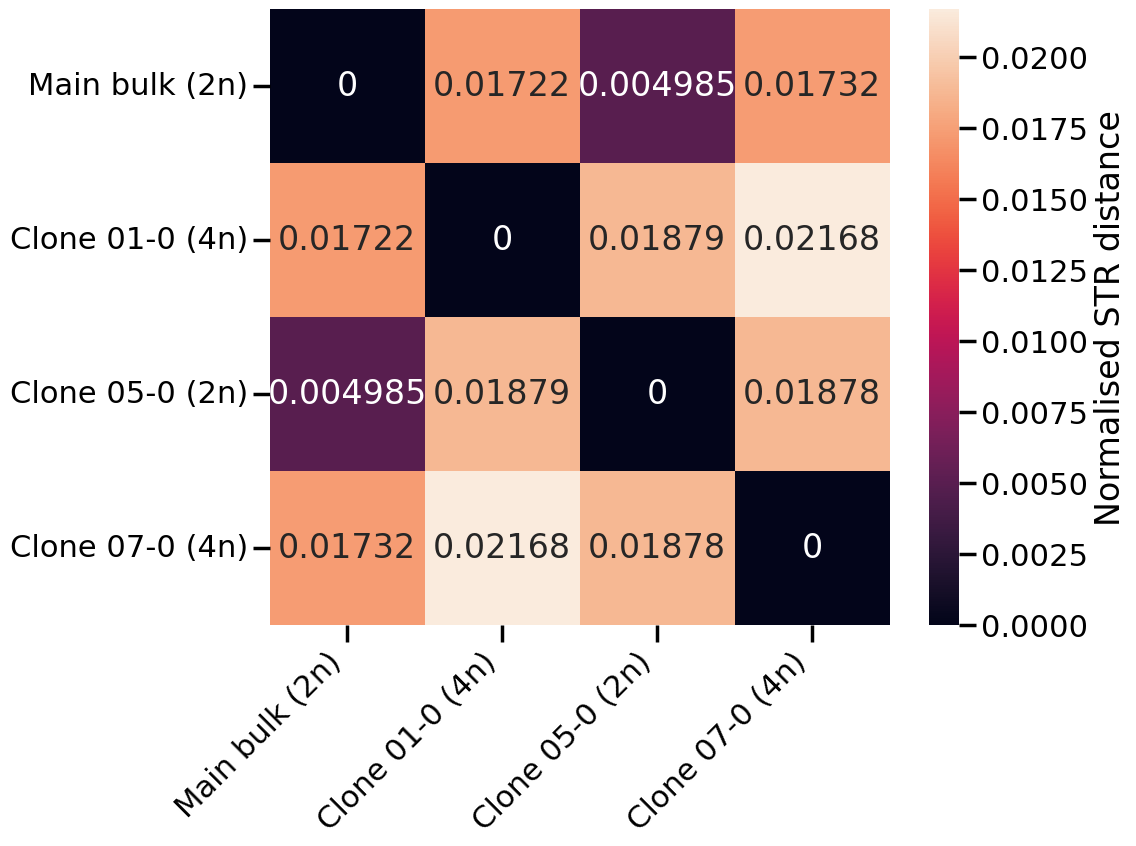

In [14]:
fig = plt.figure(figsize=(10, 8))

ax = sns.heatmap(
    data = df_distances,
    annot=True,
    fmt=".4g",
    cbar_kws={'label': 'Normalised STR distance'}
)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')